In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


Original shape: (480, 640)
Intesity: [366 366 366 365 366 366 366 366 366 366 366 366 366 366 366 366 366 366
 366 366 366 366 366 366 366 366 366 366 366 366 366 366 366 366 366 366
 366 366 366 366 366 366 366 366 366 366 366 366 366 366 366 366 366 366
 366 366 366 366 366 366 366 366 366 366 366 366 366 366 366 366 366 366
 366 366 366 366 366 372 372 372 372 365 372 372 372 365 371 371 371 371
 371 371 371 365 365 365 372 372 372 372 372 372 372 372 372 372 372 365
 365 365 365 365 365 365 365 365 365 365 365 365 365 365 365 365 365 365
 365 365 373 373 373 373 373 365 365 365 365 365 365 365 365 365 372 366
 366 366 366 366 326 327 327 327 328 328 328 328 328 328 328 328 328 328
 328 328 328 328 328 328 328 328 328 328 328 328 328 328 328 328 328 328
 328 328 328 328 328 328 328 328 328 328 328 328 328 328 328 328 328 328
 329 329 329 329 329 329 329 329 329 329 329 329 329 329 329 329 329 329
 329 329 329 329 330 330 329 329 329 330 330 330 329 329 329 329 329 330
 330 330 330 3

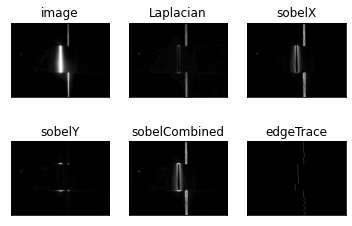

In [8]:
def cropFrame(frame):
    print("Original shape:",frame.shape)
    frame = frame[:, :]
    return frame

def applyGaussianBlur(frame):
    frame = cv2.GaussianBlur(frame, (7, 7), 0)
    frame = cv2.GaussianBlur(frame, (7, 7), 0)
    frame = cv2.GaussianBlur(frame, (7, 7), 0)
    return frame

def findGradientPoints(frame):
    list = []
    for i in range(0, frame.shape[0]):
        for j in range(1, frame.shape[1] - 1):
            if frame[i][j - 1] < frame[i][j] and frame[i][j + 1] < frame[i][j]:
                list.append((i, j))
    
    newImage = np.zeros(frame.shape)
    for point in list:
        newImage[point[0]][point[1]] = 255
    return newImage, list

def preprocessImage(gradientPoints):
    standardDeviation = np.std(gradientPoints, axis=0)
    mean = np.mean(gradientPoints, axis=0)
    # print("Standard Deviation:", standardDeviation)
    # print("Mean:", mean)

def gradientTests(frame):
    lap = cv2.Laplacian(frame, cv2.CV_64F, ksize=3)
    lap = np.uint8(np.absolute(lap))
    sobelX = cv2.Sobel(frame, cv2.CV_64F, 1, 0)
    sobelY = cv2.Sobel(frame, cv2.CV_64F, 0, 1)

    sobelX = np.uint8(np.absolute(sobelX))
    sobelY = np.uint8(np.absolute(sobelY))

    sobelCombined = cv2.bitwise_or(sobelX, sobelY)

    maxIntensity = np.argmax(sobelX, axis=1)
    edgeTrace = np.zeros(frame.shape)
    for i in range(frame.shape[0]):
        edgeTrace[i][maxIntensity[i]] = 255
    # print("Edge Trace Test:", edgeTrace)

    titles = ['image', 'Laplacian', 'sobelX', 'sobelY', 'sobelCombined', 'edgeTrace']

    images = [frame, lap, sobelX, sobelY, sobelCombined, edgeTrace]
    for i in range(6):
        plt.subplot(2, 3, i+1), plt.imshow(images[i], 'gray')
        plt.title(titles[i])
        plt.xticks([]),plt.yticks([])

    # plt.show()
    return maxIntensity, edgeTrace

def getReferenceFrame():
    referenceFrames = []
    referenceFrames = extract_frames("updated_reference")
    referenceFrame = np.zeros_like(referenceFrames[0])
    for frame in referenceFrames:
        croppedFrame = cropFrame(frame)
        blurredFrame = applyGaussianBlur(croppedFrame)
        _, edgeTrace = gradientTests(blurredFrame)
        referenceFrame = referenceFrame.astype(np.float64) + edgeTrace.astype(np.float64)
        referenceFrame = np.uint8(referenceFrame)
        break
    referenceFrameIdx = []
    for i in range(referenceFrame.shape[0]):
        for j in range(0, referenceFrame.shape[1]):
                if referenceFrame[i][j] > 0:
                    referenceFrameIdx.append((i, j))

    meanReference = np.argmax(np.mean(referenceFrame, axis=0))
    print("Reference Frame index:", meanReference)
    referenceFrame = np.zeros_like(referenceFrames[0])
    for i in range(referenceFrame.shape[0]):
        referenceFrame[i][meanReference] = 255
    
    return meanReference, referenceFrame


def getPixelDisplacement(calibrationObject, meanReference, referenceThreshold = 360, lowerBoundThreshold = 50, upperBoundThreshold = 30, extension = ".avi"):
    calibrationFrames = extract_frames(calibrationObject, extension)
    calibrationValues = []
    for frame in calibrationFrames:
        blurredFrame = applyGaussianBlur(frame)
        intensity, edgeTrace = gradientTests(blurredFrame)
        filteredIntensity = [value for value in intensity if abs(value) <= referenceThreshold]    # Filter out values that are less than 10
        pixelDisplacement = filteredIntensity - meanReference
        pixelDisplacement = abs(np.mean(pixelDisplacement))
        print("Pixel Disparity TEST:", pixelDisplacement)
        if np.isnan(pixelDisplacement) or pixelDisplacement <= lowerBoundThreshold or pixelDisplacement >= upperBoundThreshold:     # No pixel displacement detected
            # print("No pixel displacement detected")
            continue
        calibrationValues.append(pixelDisplacement)
    return calibrationValues, np.mean(calibrationValues)

meanReference = 376
frame = cv2.imread("./video_frames/grey_step_8.94mm/frame_00012.jpg", cv2.IMREAD_GRAYSCALE)
croppedFrame = cropFrame(frame)
blurredFrame = applyGaussianBlur(croppedFrame)
intensity, edgeTrace = gradientTests(blurredFrame)
filteredIntensity = [value for value in intensity if abs(value) <= 360]    # Filter out values that are less than 10
pixelDisplacement  =  pixelDisplacement = [abs(value - meanReference) for value in filteredIntensity]
print("Intesity:", intensity)


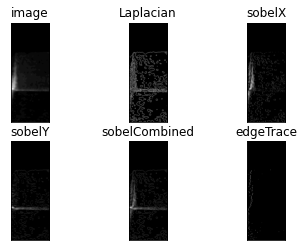

ValueError: too many values to unpack (expected 2)

In [5]:

meanReference = 376
frame = cv2.imread("./video_frames/grey_step_8.94mm/frame_00012.jpg", cv2.IMREAD_GRAYSCALE)
croppedFrame = cropFrame(frame)
blurredFrame = applyGaussianBlur(croppedFrame)
intensity, edgeTrace = gradientTests(blurredFrame)
filteredIntensity = [value for value in intensity if abs(value) <= 360]    # Filter out values that are less than 10
pixelDisplacement  =  abs(filteredIntensity - meanReference)
print("Intesity:", intensity)